In [5]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md

In [6]:
pdb='/home/f0042vb/CHEM101.6/week5/Villin_Lab/2F4K.protein.pdb'
trajectory='/home/f0042vb/CHEM101.6/week5/Villin_Lab/2F4K.protein.s10.dcd'
xray_CA_pdb='/home/f0042vb/CHEM101.6/week5/Villin_Lab/2f4K.xray.CA.pdb'
outdir='/home/f0042vb/CHEM101.6/week5/output'
if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)

outdir: /home/f0042vb/CHEM101.6/week5/output
pdb: /home/f0042vb/CHEM101.6/week5/Villin_Lab/2F4K.protein.pdb
trjaectory: /home/f0042vb/CHEM101.6/week5/Villin_Lab/2F4K.protein.s10.dcd


In [7]:
stride_sel=5
trj = md.load(trajectory, top=pdb,stride=stride_sel)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames
trj_length=125
time=np.linspace(0,125,n_frames)

nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)

** SYSTEM INFO **

Number of atoms: 577

Number of residues: 35

Number of frames: 12559

Starting frame: 0

Last frame: 12559

sequence:  [LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76, LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76]

residue names:  ['LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA', 'PHE', 'ALA', 'ASN', 'LEU', 'PRO', 'LEU', 'TRP', 'NLE', 'GLN', 'GLN', 'HIS', 'LEU', 'NLE', 'LYS', 'GLU', 'LYS', 'GLY', 'LEU', 'PHE', 'LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'A

In [8]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)

xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top_xray.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76])

In [9]:
trjCA = md.load(trajectory, top=pdb,stride=stride_sel)
CA=top.select("name CA")
trjCA.restrict_atoms(CA)
trjCA.center_coordinates()

<mdtraj.Trajectory with 12559 frames, 35 atoms, 35 residues, and unitcells at 0x7374800d4990>

In [10]:
native_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   #print(i,j)
   dist=md.compute_distances(xray_CA,[[i,j]])[0][0]
   native_distance_matrix1D.append(dist)

#Convert to Angstrom
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10

In [11]:
Native_Contacts=np.where(native_distance_matrix1D<10)
Native_Contact_Distances=native_distance_matrix1D[Native_Contacts]
np.shape(Native_Contact_Distances)

(148,)

In [12]:
from tqdm import trange

traj_CA_distance_matrix1D=[]
for i in trange(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   dist=md.compute_distances(trjCA,[[i,j]])[:,0]
   traj_CA_distance_matrix1D.append(dist)

#Convert to Angstrom
traj_CA_distance_matrix1D=np.asarray(traj_CA_distance_matrix1D)*10
Traj_Native_Contact_Distances=traj_CA_distance_matrix1D[Native_Contacts]
Traj_CA_Distnaces=traj_CA_distance_matrix1D[Native_Contacts]




100%|██████████| 34/34 [02:19<00:00,  4.09s/it]


In [13]:
#Now Lets Filter Our Distances based on only the "Native Portion of the Trajectory" and recompute Q
rmsd = md.rmsd(trjCA,xray_CA)
native_frames=np.where(rmsd<0.25)[0]

trj_native_distances=traj_CA_distance_matrix1D[:,native_frames]

averages=np.average(trj_native_distances,axis=1)
Native_Contacts=np.where(averages<10.0)[0]

Native_CA_Distances=native_distance_matrix1D[Native_Contacts]
Traj_CA_Distnaces=traj_CA_distance_matrix1D[Native_Contacts]

#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Native_Contact_Distances_nframes=np.zeros(np.shape(Traj_CA_Distnaces))
for i in range(0,len(Native_CA_Distances)):
 Native_Contact_Distances_nframes[i]=Native_CA_Distances[i]

np.shape(Native_Contact_Distances_nframes)





(46, 12559)

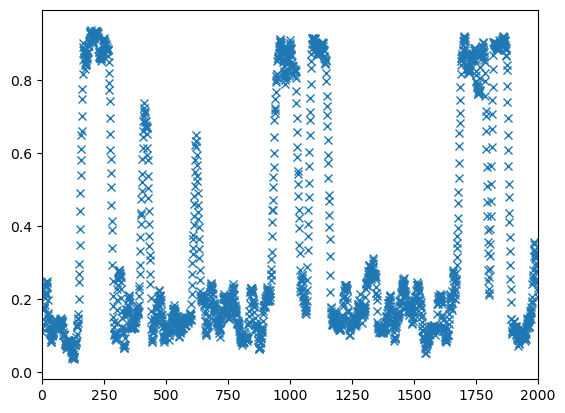

In [14]:
# Smooth the Q value

def smooth(array, window_size=19):
    # Calculate the amount of padding needed
    pad_size = window_size // 2
    
    # Pad the array on both ends with the edge values
    padded_array = np.pad(array, pad_size, mode='edge')
    
    # Create a simple moving average filter (boxcar)
    window = np.ones(window_size) / window_size
    
    # Apply the filter
    smoothed_array = np.convolve(padded_array, window, mode='valid')
    
    return smoothed_array




Q=1/(1+np.exp(10*(Traj_CA_Distnaces-(Native_Contact_Distances_nframes+1))))
Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_CA_Distances)

Q_smooth  = smooth(Q)
plt.plot(Q_smooth,marker='x',linewidth=.01)
plt.xlim(0,2000)
plt.show()




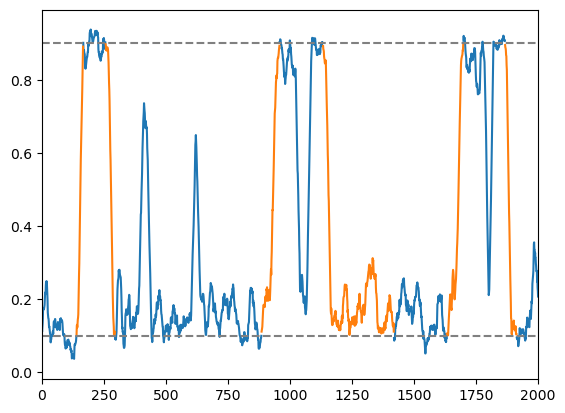

In [15]:
def assign_states(data, lower=0.1, upper=0.9):
    # define unfolded as 0; folded as 1
    state = []
    # assign the first frame arbitrarily with a state
    state.append(0)
    this_state = 0
    for q in data[1::]:
        
        if q < lower:
            this_state = 0
        elif q > upper:
            this_state = 1

        
        state.append(this_state)
    return np.array(state)

state_forward = assign_states(Q_smooth)

state_backward = assign_states(Q_smooth[::-1])[::-1]

transition_path = (state_forward != state_backward)

tran = np.ma.masked_where(transition_path,Q_smooth)
nontran = np.ma.masked_where(~transition_path,Q_smooth)

frame = range(len(transition_path))

plt.plot(frame, tran,frame,nontran)
plt.axhline(0.1,linestyle='--',color="grey")
plt.axhline(0.9,linestyle='--',color="grey")
plt.xlim(0,2000)
plt.show()
        


    

In [17]:
# Calculate the contact distance of unfolded state and on the transition path:

distance_path = np.abs(Traj_CA_Distnaces)[:,transition_path]
print(Traj_CA_Distnaces[:,Q_smooth<0.1].mean())
print(distance_path.mean())


16.440128
12.7830715


In [42]:
#Identify separate path in transition path:

def extract_true_segments(arr):

    arr = np.asarray(arr)
    
    # Start and end positions of segments of True
    # pad the array with False at both ends to detect boundaries correctly
    padded = np.pad(arr, (1, 1), mode='constant', constant_values=False)
    
    diff = np.diff(padded.astype(int))
    
    start_positions = np.where(diff == 1)[0]
    end_positions = np.where(diff == -1)[0]
    
    segments = [list(range(start, end)) for start, end in zip(start_positions, end_positions)]
    
    return segments

path_segments = extract_true_segments(transition_path)

#print the length of each path
print(list(map(len,path_segments)))

[27, 39, 73, 286, 67, 47, 56, 141, 165, 89, 189, 107, 118, 72, 19, 173, 76, 29, 116, 33, 176, 39, 57, 79, 41, 18, 38, 45, 21, 37, 35, 25, 57, 88, 196, 109]


Now, let's plot a long transition path and short transition path on rmsd-Q free energy diagram.

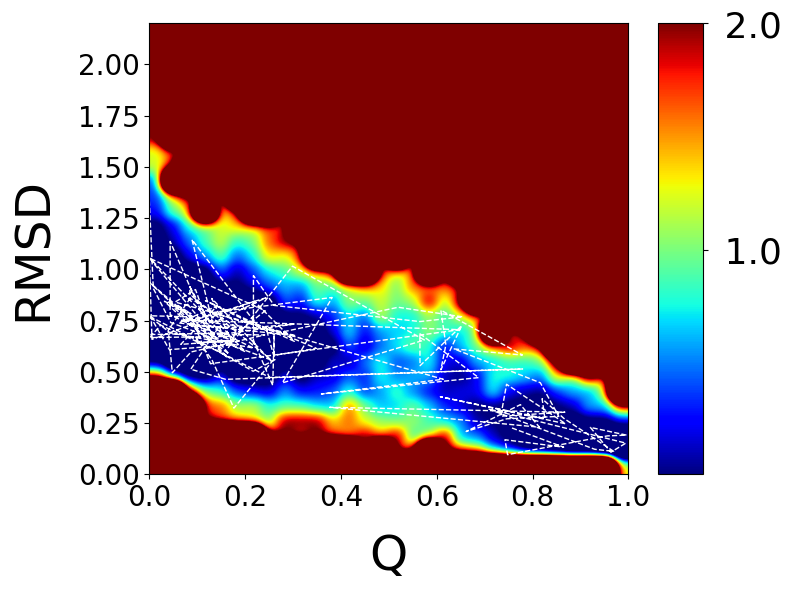

In [58]:
def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], density=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

dG,xedges,yedges=free_energy(rmsd, Q, 300, 0, 2.2, 0, 1)

Q_longpath = Q[np.array(path_segments[7])]
rmsd_longpath = rmsd[np.array(path_segments[7])]

fig = plt.figure(figsize=(8, 6))

im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,1,2]

cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='20')
plt.yticks(size='20')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=2.0)
plt.yticks(size='26')
plt.sca(imaxes)
plt.plot(Q_longpath,rmsd_longpath,color='white', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()


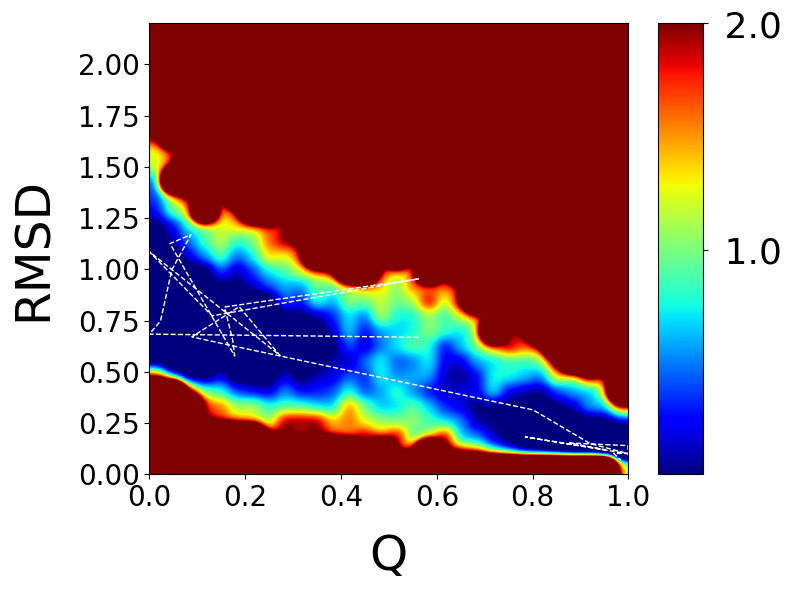

In [60]:
Q_shortpath = Q[np.array(path_segments[0])]
rmsd_shortpath = rmsd[np.array(path_segments[0])]

fig = plt.figure(figsize=(8, 6))

im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,1,2]

cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='20')
plt.yticks(size='20')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=2.0)
plt.yticks(size='26')
plt.sca(imaxes)
plt.plot(Q_shortpath,rmsd_shortpath,color='white', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()


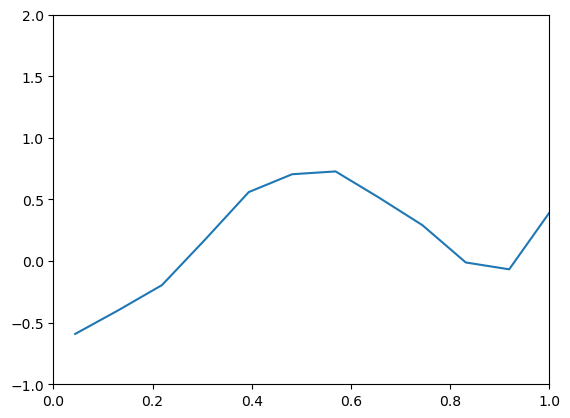

In [65]:
# Free energy diagram along the transition path:

def free_energy1D(a,T,x0,xmax,bins):
    free_energy, xedges= np.histogram(
        a, bins, [x0, xmax], density=True, weights=None)
    xcenters= xedges[:-1] + np.diff(xedges)/2
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xcenters

dG_RMSD,xedges=free_energy1D(Q[transition_path],300,0,1.75,20)
plt.xlim(0,1)
plt.ylim(-1,2)
plt.plot(xedges,dG_RMSD)
plt.show()

Calculate the side-chain and backbone entropy in folded and unfolded states:

In [34]:

# Calculate dihedral angles
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)


# Bin the angles and calculate entropy
def calc_entropy(angles):
    hist, bin_edges = np.histogram(angles, bins=100, density=True)

    non_zero_indices = hist > 0
    hist_filtered = hist[non_zero_indices]
    bin_widths = np.diff(bin_edges)[non_zero_indices]
    return -np.sum(hist_filtered * np.log(hist_filtered) * bin_widths)

unfold_phis = phis[Q<0.1]
unfold_psi = psis[Q<0.1]
unfold_chi1 = chi1s[Q<0.1]
unfold_chi2 = chi2s[Q<0.1]

fold_phis = phis[Q>0.9]
fold_psi = psis[Q>0.9]
fold_chi1 = chi1s[Q>0.9]
fold_chi2 = chi2s[Q>0.9]

unfold_backbone_entropy = calc_entropy(unfold_phis) + calc_entropy(unfold_psi)
unfold_sidechain_entropy = calc_entropy(unfold_chi1) + calc_entropy(unfold_chi2)

fold_backbone_entropy = calc_entropy(fold_phis) + calc_entropy(fold_psi)
fold_sidechain_entropy = calc_entropy(fold_chi1) + calc_entropy(fold_chi2)

print(f"Total Unfolded Backbone Entropy: {unfold_backbone_entropy:.03f}")
print(f"Total Unfolded Side-chain Entropy: {unfold_sidechain_entropy:.03f}")
print(f"Total folded Backbone Entropy: {fold_backbone_entropy:.03f}")
print(f"Total folded Side-chain Entropy: {fold_sidechain_entropy:.03f}")

Total Unfolded Backbone Entropy: 2.099
Total Unfolded Side-chain Entropy: 2.400
Total folded Backbone Entropy: 1.324
Total folded Side-chain Entropy: 2.393
